<a href="https://colab.research.google.com/github/a77anX/a77anx.github.io/blob/main/bully.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Using device: cpu with 4 CPU threads

Loading and preprocessing data...
Data preprocessing complete
Class distribution:
label
0    148
1     17
Name: count, dtype: int64

Initializing model training...


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

Device set to use cpu


Applying text augmentations...


tokenizer_config.json:   0%|          | 0.00/151 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/132 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training (this may take a while on CPU)...
{'loss': 0.5699, 'grad_norm': 8.676714897155762, 'learning_rate': 4.0625000000000005e-05, 'epoch': 0.6060606060606061}
{'eval_loss': 0.2982785403728485, 'eval_accuracy': 0.9696969696969697, 'eval_f1': 0.8, 'eval_precision': 1.0, 'eval_recall': 0.6666666666666666, 'eval_runtime': 11.7082, 'eval_samples_per_second': 2.819, 'eval_steps_per_second': 0.769, 'epoch': 1.0}
{'loss': 0.321, 'grad_norm': 2.332998037338257, 'learning_rate': 3.0208333333333334e-05, 'epoch': 1.1818181818181819}
{'loss': 0.2429, 'grad_norm': 3.203991651535034, 'learning_rate': 1.9791666666666665e-05, 'epoch': 1.7878787878787878}
{'eval_loss': 0.12060309201478958, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 11.8965, 'eval_samples_per_second': 2.774, 'eval_steps_per_second': 0.757, 'epoch': 2.0}
{'loss': 0.0644, 'grad_norm': 0.4271047115325928, 'learning_rate': 9.375000000000001e-06, 'epoch': 2.3636363636363638}
{'

Map:   0%|          | 0/33 [00:00<?, ? examples/s]


Classification Report:
               precision    recall  f1-score   support

         Safe       0.97      1.00      0.98        30
Cyberbullying       1.00      0.67      0.80         3

     accuracy                           0.97        33
    macro avg       0.98      0.83      0.89        33
 weighted avg       0.97      0.97      0.97        33



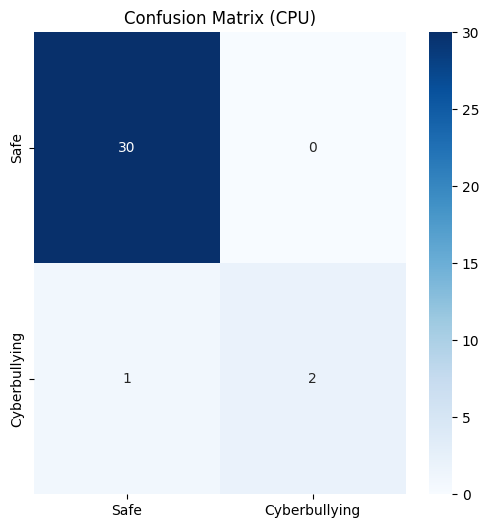

Metrics saved to metrics_cpu.csv

Loading model from ./cyberbullying_model_cpu...
Model loaded successfully

Running test predictions:

Text: Buang ka! (Hiligaynon offensive)
Prediction: Cyberbullying
Confidence: 0.99
Triggers: ['buang']

Text: Great work everyone! (Benign English)
Prediction: Safe
Confidence: 0.95

Text: You're so stupid (English offensive)
Prediction: Safe
Confidence: 0.52

Text: Maayo nga adlaw! (Benign Hiligaynon)
Prediction: Cyberbullying
Confidence: 0.68

Text: Pokpok ya siya (Severe Hiligaynon slur)
Prediction: Cyberbullying
Confidence: 0.99
Triggers: ['pokpok']

CPU-optimized pipeline execution complete!


In [2]:
# Standard library imports
import os
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Third-party imports
import torch
import numpy as np
import pandas as pd
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    recall_score,
    precision_score
)
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    pipeline
)
from textattack.augmentation import WordNetAugmenter
from torch import nn
from langdetect import detect

# ===================== SYSTEM CONFIGURATION =====================
# Force CPU usage and optimize performance
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["OMP_NUM_THREADS"] = "4"  # Adjust based on your CPU cores
torch.set_num_threads(4)
device = torch.device("cpu")
print(f"\nUsing device: {device} with {torch.get_num_threads()} CPU threads")

# ===================== HILIGAYNON OFFENSIVE WORDS =====================
HILIGAYNON_OFFENSIVE_WORDS = {
    "buang": {"severity": 8, "category": "insult"},
    "yawa": {"severity": 9, "category": "blasphemy"},
    "pokpok": {"severity": 10, "category": "slur"},
    "yot": {"severity": 9, "category": "sexual"},
    "tigulang": {"severity": 5, "category": "ageism"},
    "bogo": {"severity": 7, "category": "insult"},
    "patay-gutom": {"severity": 6, "category": "classist"},
    "sira-ulo": {"severity": 7, "category": "mental-health"},
    "ignorante": {"severity": 6, "category": "insult"}
}

# ===================== DATA LOADING AND PREPROCESSING =====================
def load_and_preprocess_data():
    """Load and preprocess dataset with CPU-optimized operations"""
    print("\nLoading and preprocessing data...")

    # Load dataset with low_memory for CPU efficiency
    df = pd.read_csv("cyberbullying_dataset2.csv", engine='python')

    # Standardize columns
    column_mapping = {
        'tweet_text': 'text',
        'cyberbullying_type': 'label'
    }
    df.rename(columns={k:v for k,v in column_mapping.items() if k in df.columns}, inplace=True)

    # Convert labels (optimized with numpy)
    df['label'] = np.where(df['label'] == "normal", 0, 1)

    # Enhanced text cleaning with vectorized operations
    def clean_text(text):
        text = str(text)
        text = emoji.demojize(text, delimiters=(" [", "] "))
        text = re.sub(r'(\w)\1{2,}', r'\1', text)  # Remove character repetitions
        text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace

        # Detect offensive words (case-insensitive)
        hil_offensive = any(
            re.search(rf'\b{re.escape(word)}\b', text.lower())
            for word in HILIGAYNON_OFFENSIVE_WORDS
        )

        # Language detection with fallback
        try:
            lang = detect(text) if len(text) > 10 else "unknown"
        except:
            lang = "unknown"

        return text, hil_offensive, lang

    # Apply preprocessing (using parallel pandas operations)
    df[['text', 'hiligaynon_offensive', 'language']] = pd.DataFrame(
        df['text'].apply(clean_text).tolist(),
        index=df.index
    )

    print("Data preprocessing complete")
    print(f"Class distribution:\n{df['label'].value_counts()}")

    return df

# ===================== DATA AUGMENTATION =====================
class CPUAugmenter:
    """CPU-optimized text augmentation"""
    def __init__(self):
        self.wordnet_aug = WordNetAugmenter()
        self.translator = pipeline(
            "translation",
            model="facebook/nllb-200-distilled-600M",
            device=-1,  # Force CPU
            max_length=100  # Reduced for CPU
        )

    def back_translate(self, text, src_lang="eng_Latn", tgt_lang="ceb_Latn"):
        """Simplified back-translation for CPU"""
        try:
            translated = self.translator(text, src_lang=src_lang, tgt_lang=tgt_lang)[0]['translation_text']
            back_translated = self.translator(translated, src_lang=tgt_lang, tgt_lang=src_lang)[0]['translation_text']
            return back_translated
        except Exception as e:
            print(f"Skipping back-translation (CPU limitation): {str(e)[:100]}")
            return text

    def augment(self, text, label, is_hiligaynon):
        """Apply CPU-friendly augmentations"""
        # WordNet augmentation (30% chance)
        if label == 1 and np.random.rand() < 0.3:
            try:
                text = self.wordnet_aug.augment(text)[0]
            except:
                pass

        # Back-translation (20% chance for Hiligaynon)
        if is_hiligaynon and np.random.rand() < 0.2:
            text = self.back_translate(text)

        return text

# ===================== MODEL TRAINING =====================
def train_model(df):
    """CPU-optimized training pipeline"""
    print("\nInitializing model training...")

    # Initialize augmenter
    augmenter = CPUAugmenter()

    # Split data (stratified for class balance)
    train_df, val_df = train_test_split(
        df,
        test_size=0.2,
        random_state=42,
        stratify=df['label']
    )

    # Apply augmentations to training set
    print("Applying text augmentations...")
    train_df['text'] = train_df.apply(
        lambda row: augmenter.augment(
            row['text'],
            row['label'],
            row['hiligaynon_offensive']
        ),
        axis=1
    )

    # Tokenization with CPU-optimized settings
    tokenizer = AutoTokenizer.from_pretrained("GroNLP/hateBERT")

    def tokenize_function(batch):
        return tokenizer(
            batch['text'],
            truncation=True,
            max_length=100,  # Reduced sequence length
            padding='longest'  # Dynamic padding for CPU efficiency
        )

    # Create datasets
    train_dataset = Dataset.from_pandas(train_df).map(
        tokenize_function,
        batched=True,
        batch_size=32  # Smaller batches for CPU
    )
    val_dataset = Dataset.from_pandas(val_df).map(
        tokenize_function,
        batched=True,
        batch_size=32
    )

    # Compute class weights
    class_weights = torch.tensor(
        compute_class_weight(
            'balanced',
            classes=np.unique(train_df['label']),
            y=train_df['label']
        ),
        dtype=torch.float32
    )

    # Custom trainer for CPU with updated compute_loss
    class CPUTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            loss_fct = nn.CrossEntropyLoss(weight=class_weights)
            loss = loss_fct(outputs.logits.view(-1, 2), labels.view(-1))
            return (loss, outputs) if return_outputs else loss

    # Initialize model
    model = AutoModelForSequenceClassification.from_pretrained(
        "GroNLP/hateBERT",
        num_labels=2
    ).to(device)

    # Updated training arguments with eval_strategy
    training_args = TrainingArguments(
        output_dir="./cpu_results",
        eval_strategy="epoch",  # Updated from evaluation_strategy
        per_device_train_batch_size=4,  # Small batches for CPU
        per_device_eval_batch_size=4,
        num_train_epochs=3,  # Reduced epochs
        logging_steps=10,
        save_strategy="no",  # Disable checkpoints
        report_to="none",
        fp16=False,  # Disable mixed precision
        gradient_accumulation_steps=2,  # Simulate larger batches
        optim="adamw_torch",  # Standard optimizer
        disable_tqdm=True  # Reduce overhead
    )

    # Initialize trainer
    trainer = CPUTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=lambda p: {
            'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1)),
            'f1': f1_score(p.label_ids, np.argmax(p.predictions, axis=1)),
            'precision': precision_score(p.label_ids, np.argmax(p.predictions, axis=1)),
            'recall': recall_score(p.label_ids, np.argmax(p.predictions, axis=1))
        }
    )

    # Train model
    print("Starting training (this may take a while on CPU)...")
    trainer.train()

    # Save final model
    trainer.save_model("./cyberbullying_model_cpu")
    tokenizer.save_pretrained("./cyberbullying_model_cpu")
    print("\nTraining complete. Model saved to ./cyberbullying_model_cpu")

    return trainer, val_df

# ===================== EVALUATION =====================
def evaluate_model(trainer, val_df):
    """Comprehensive model evaluation"""
    print("\nEvaluating model performance...")

    # Prepare validation dataset
    tokenizer = AutoTokenizer.from_pretrained("./cyberbullying_model_cpu")
    val_dataset = Dataset.from_pandas(val_df).map(
        lambda x: tokenizer(x['text'], truncation=True, max_length=100),
        batched=True
    )

    # Get predictions
    predictions = trainer.predict(val_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    # Classification report
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=["Safe", "Cyberbullying"]))

    # Confusion matrix
    plt.figure(figsize=(6,6))
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Safe", "Cyberbullying"],
                yticklabels=["Safe", "Cyberbullying"])
    plt.title("Confusion Matrix (CPU)")
    plt.savefig('confusion_matrix_cpu.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save metrics
    metrics = {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds),
        'precision': precision_score(labels, preds),
        'recall': recall_score(labels, preds)
    }
    pd.DataFrame.from_dict(metrics, orient='index').to_csv('metrics_cpu.csv')
    print("Metrics saved to metrics_cpu.csv")

# ===================== INFERENCE PIPELINE =====================
class CPUCyberbullyingDetector:
    """CPU-optimized inference"""
    def __init__(self, model_path):
        print(f"\nLoading model from {model_path}...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.model.eval().to(device)
        print("Model loaded successfully")

    def predict(self, text, threshold=0.7):
        # Priority 1: Direct Hiligaynon word match
        triggers = [
            word for word in HILIGAYNON_OFFENSIVE_WORDS
            if re.search(rf'\b{re.escape(word)}\b', text.lower())
        ]

        if triggers:
            return {
                "label": "Cyberbullying",
                "confidence": 0.99,
                "triggers": triggers,
                "is_cyberbullying": True
            }

        # Priority 2: Model prediction
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=100
        )
        with torch.no_grad():
            outputs = self.model(**inputs)

        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        pred_class = torch.argmax(probs).item()
        confidence = probs[0][pred_class].item()

        return {
            "label": "Cyberbullying" if pred_class == 1 else "Safe",
            "confidence": confidence,
            "is_cyberbullying": confidence > threshold and pred_class == 1
        }

# ===================== MAIN EXECUTION =====================
if __name__ == "__main__":
    # Data loading and preprocessing
    df = load_and_preprocess_data()

    # Model training
    trainer, val_df = train_model(df)

    # Evaluation
    evaluate_model(trainer, val_df)

    # Initialize detector
    detector = CPUCyberbullyingDetector("./cyberbullying_model_cpu")

    # Test cases
    test_samples = [
        ("Buang ka!", "Hiligaynon offensive"),
        ("Great work everyone!", "Benign English"),
        ("You're so stupid", "English offensive"),
        ("Maayo nga adlaw!", "Benign Hiligaynon"),
        ("Pokpok ya siya", "Severe Hiligaynon slur")
    ]

    print("\nRunning test predictions:")
    for text, desc in test_samples:
        result = detector.predict(text)
        print(f"\nText: {text} ({desc})")
        print(f"Prediction: {result['label']}")
        print(f"Confidence: {result['confidence']:.2f}")
        if 'triggers' in result:
            print(f"Triggers: {result['triggers']}")

    print("\nCPU-optimized pipeline execution complete!")